In [1]:
! git clone https://github.com/Bhavay-Garg/Lung-Disease-Detection.git

Cloning into 'Lung-Disease-Detection'...
remote: Enumerating objects: 10118, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10118 (delta 1), reused 10 (delta 1), pack-reused 10108
Receiving objects: 100% (10118/10118), 2.17 GiB | 25.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (10101/10101), done.


In [1]:
import torch
import numpy as np


In [2]:
!pip install timm # install PyTorch Image Models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torchvision import transforms as T,datasets
test_transform = T.Compose([
                             
                             T.Resize(size=(300,300)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])
testset=datasets.ImageFolder("/content/Lung-Disease-Detection/Dataset/test",transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  2025


In [3]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
testloader = DataLoader(testset,batch_size=16,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:127
No. of Total examples:2025


In [4]:
import timm # PyTorch Image Models
from torch import nn

model = timm.create_model("tf_efficientnet_b3_ns",pretrained=True) 
model.classifier = nn.Sequential(
    nn.Linear(in_features=1536, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=5), 
)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


In [5]:
from torchsummary import  summary
model.to('cuda') # move the model to GPU
summary(model,input_size=(3,300,300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 40, 150, 150]           1,080
          Identity-2         [-1, 40, 150, 150]               0
              SiLU-3         [-1, 40, 150, 150]               0
    BatchNormAct2d-4         [-1, 40, 150, 150]              80
            Conv2d-5         [-1, 40, 150, 150]             360
          Identity-6         [-1, 40, 150, 150]               0
              SiLU-7         [-1, 40, 150, 150]               0
    BatchNormAct2d-8         [-1, 40, 150, 150]              80
            Conv2d-9             [-1, 10, 1, 1]             410
             SiLU-10             [-1, 10, 1, 1]               0
           Conv2d-11             [-1, 40, 1, 1]             440
          Sigmoid-12             [-1, 40, 1, 1]               0
    SqueezeExcite-13         [-1, 40, 150, 150]               0
           Conv2d-14         [-1, 24, 1

In [6]:
model.load_state_dict(torch.load('/content/ColabModel.pt'))
model.eval()


EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [7]:
import matplotlib.pyplot as plt
def view_classify(image,ps,label):
    
    class_name = ["Bacterial Pneumonia","Corona Virus Disease","Normal","Tuberculosis","Viral Pneumonia"]
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

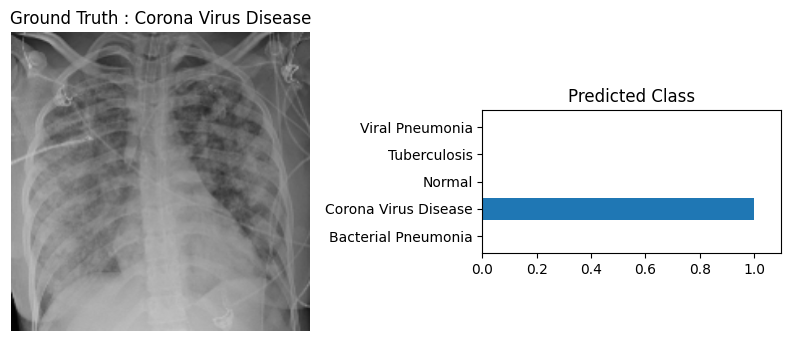

In [8]:
import torch.nn.functional as F

image,label = testset[500]

ps = model(image.to("cuda").unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [9]:
actual=[]
predicted=[]
for i in  range(len(testloader)):
    inputs, classes = next(iter(testloader))
    
    model = model.to("cuda")
    inputs=inputs.to("cuda")
    
    outputs=model(inputs)
    _, preds = torch.max(outputs, 1)
    preds=preds.cpu().numpy()
    classes=classes.numpy()
    print(i)
    print(preds)
    print(classes)
    actual.extend(classes)
    predicted.extend(preds)

0
[1 0 2 3 2 2 3 4 3 1 1 2 1 1 0 2]
[0 0 2 3 2 2 1 0 3 1 1 0 1 1 4 2]
1
[2 3 1 3 2 4 3 3 0 0 1 4 2 4 3 0]
[2 3 1 3 2 4 3 3 0 0 1 0 0 4 3 0]
2
[3 4 2 0 4 2 0 3 0 0 4 1 4 4 2 2]
[3 4 2 4 4 2 0 3 4 0 4 1 4 0 0 2]
3
[4 4 2 2 2 2 2 4 1 0 3 0 1 3 0 4]
[4 4 2 2 2 2 4 4 1 0 3 0 1 3 0 0]
4
[0 2 2 4 3 3 2 1 0 1 2 4 3 0 0 1]
[0 2 2 4 3 3 2 1 0 1 2 4 1 0 0 1]
5
[2 3 2 4 1 2 0 2 1 3 2 4 1 4 2 3]
[2 3 2 4 1 2 0 2 1 3 2 0 1 4 0 3]
6
[1 1 3 3 4 2 0 2 0 4 1 2 2 0 2 0]
[1 1 3 3 4 0 4 2 0 4 1 4 2 0 2 0]
7
[4 1 0 1 3 4 3 3 1 3 1 0 1 3 3 0]
[4 1 0 1 3 0 3 0 1 3 1 0 1 3 3 0]
8
[1 0 3 2 0 4 2 2 3 4 2 3 1 0 4 4]
[1 4 3 2 0 4 2 2 3 4 2 3 1 0 4 4]
9
[2 1 1 3 2 3 0 0 0 1 1 3 0 0 3 2]
[2 1 1 3 2 3 0 0 0 1 1 3 0 0 3 2]
10
[2 4 3 3 3 3 0 1 2 3 2 4 2 2 4 2]
[2 0 3 1 3 3 4 1 2 3 2 4 2 2 4 2]
11
[0 1 0 2 2 4 1 4 1 1 4 0 2 2 2 0]
[0 1 4 2 2 4 1 3 1 1 4 0 2 2 0 0]
12
[2 4 4 0 3 1 2 3 0 0 1 4 0 4 0 4]
[0 0 4 1 3 4 4 3 0 0 3 4 0 0 0 4]
13
[0 2 4 3 3 4 0 1 1 3 3 0 3 2 4 1]
[0 2 4 3 3 4 0 1 1 3 3 0 1 2 4 1]
14
[0 2 0 0 2 3 

In [10]:
print("Actual: ",actual)
print("Predicted: ",predicted)

Actual:  [0, 0, 2, 3, 2, 2, 1, 0, 3, 1, 1, 0, 1, 1, 4, 2, 2, 3, 1, 3, 2, 4, 3, 3, 0, 0, 1, 0, 0, 4, 3, 0, 3, 4, 2, 4, 4, 2, 0, 3, 4, 0, 4, 1, 4, 0, 0, 2, 4, 4, 2, 2, 2, 2, 4, 4, 1, 0, 3, 0, 1, 3, 0, 0, 0, 2, 2, 4, 3, 3, 2, 1, 0, 1, 2, 4, 1, 0, 0, 1, 2, 3, 2, 4, 1, 2, 0, 2, 1, 3, 2, 0, 1, 4, 0, 3, 1, 1, 3, 3, 4, 0, 4, 2, 0, 4, 1, 4, 2, 0, 2, 0, 4, 1, 0, 1, 3, 0, 3, 0, 1, 3, 1, 0, 1, 3, 3, 0, 1, 4, 3, 2, 0, 4, 2, 2, 3, 4, 2, 3, 1, 0, 4, 4, 2, 1, 1, 3, 2, 3, 0, 0, 0, 1, 1, 3, 0, 0, 3, 2, 2, 0, 3, 1, 3, 3, 4, 1, 2, 3, 2, 4, 2, 2, 4, 2, 0, 1, 4, 2, 2, 4, 1, 3, 1, 1, 4, 0, 2, 2, 0, 0, 0, 0, 4, 1, 3, 4, 4, 3, 0, 0, 3, 4, 0, 0, 0, 4, 0, 2, 4, 3, 3, 4, 0, 1, 1, 3, 3, 0, 1, 2, 4, 1, 0, 2, 0, 1, 0, 3, 3, 3, 4, 4, 1, 3, 3, 4, 0, 4, 2, 4, 0, 1, 4, 1, 4, 4, 2, 1, 4, 3, 2, 1, 2, 1, 1, 1, 1, 4, 3, 0, 1, 1, 2, 4, 3, 0, 1, 2, 1, 1, 3, 4, 1, 2, 0, 4, 1, 3, 0, 4, 0, 4, 0, 0, 4, 3, 4, 3, 3, 2, 3, 1, 1, 0, 4, 1, 1, 3, 3, 2, 3, 2, 0, 1, 1, 1, 1, 1, 3, 4, 4, 4, 4, 3, 2, 2, 3, 1, 1, 2, 1, 4, 3, 3, 2, 0, 3, 4, 

In [11]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(actual, predicted)
confusion_matrix

array([[304,   4,  29,   2,  81],
       [  4, 362,   5,  32,   4],
       [  4,   2, 367,   1,   7],
       [  0,   8,   1, 420,   2],
       [ 92,   5,  41,   1, 254]])

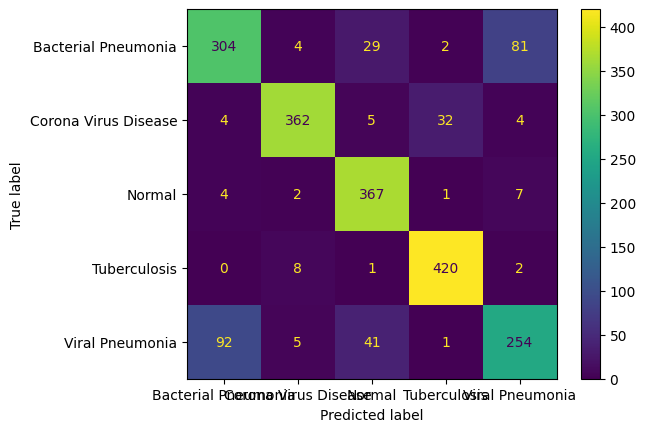

In [12]:
import matplotlib.pyplot as plt
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels =  ["Bacterial Pneumonia","Corona Virus Disease","Normal","Tuberculosis","Viral Pneumonia"])
cm_display.plot()
plt.show()

In [13]:
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted,average="micro")
Sensitivity_recall = metrics.recall_score(actual, predicted,average="micro")
F1_score = metrics.f1_score(actual, predicted,average="micro")
print("Accuracy",Accuracy)
print("Precision",Precision)
print("Sensitivity_recall",Sensitivity_recall)
print("F1_score",F1_score)

Accuracy 0.8400590551181102
Precision 0.8400590551181102
Sensitivity_recall 0.8400590551181102
F1_score 0.8400590551181102
